In [ ]:
#The aim of this script is that using Alpha shape to quantify the out-of-liquid phase parts of a protein,
#and calculate the surface area and volume of the protruding parts.
#There is a set containing all the codes at the last blank.

#本代码是为了用Alpha shape来界定界面位置，并且计算蛋白质在气相界面的部分的表面积与体积。
#最后一栏中，有一个所有代码的合集。

#このスクリプトの目的は、Alpha shapeを使って気相にあるタンパク質の部分の表面積及び体積を計算することである。

In [2]:
import os
from matplotlib import pyplot
from pylab import genfromtxt 
import statistics
import numpy as np
from numpy import exp, linspace, random
from scipy.fftpack import fft, ifft
import math
from scipy import integrate
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import alphashape

0.009509788888888898 985.5816696428572
492.795589715873
465.063
378    30.28
Name: Coordinate, dtype: float64


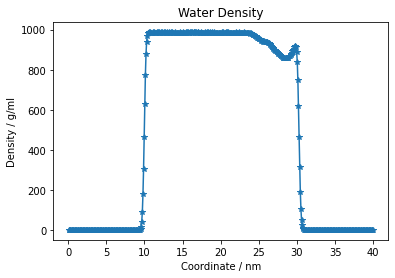

a=9.972336547502934 b=0.44026004828571474


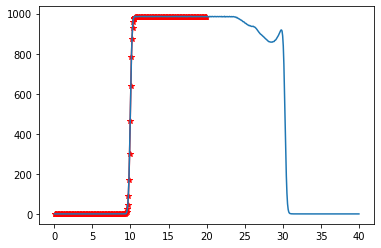

In [11]:
#Initially, it is important to identify the position of interface. This paper gives some explicit explanations:
#https://journals.aps.org/pre/abstract/10.1103/PhysRevE.79.046709

#首先，最重要的是确定界面所在位置，上述的论文给出了一些观点。

#まず、最も大切なのは界面の位置を確認すること。上記の論文はいくつかの観点を与えた。


WaterD1 = Density.Density[(Density['Coordinate'] >  1) & (Density['Coordinate'] <  9)]
WaterD2 = Density.Density[(Density['Coordinate'] >  11) & (Density['Coordinate'] <  20)]

        
rD1 = np.mean(WaterD1) 
rD2 = np.mean(WaterD2)
print(rD1,rD2)
interface = 1/2*(rD1+rD2)
print(interface)
#Calculating the water density at the interface.

dv = min(Density.Density,key = lambda x:abs(x-interface))
print(dv)
#Finding the closest value in the Density file to the calculated water density value.

for k in Density.Density:
        coordinate = Density.Coordinate[Density.Density == dv]
print(coordinate)
#Finding the value of interface coordinate.

plt.plot(Density.Coordinate,Density.Density,marker='*')
plt.title('Water Density')
plt.xlabel('Coordinate / nm')
plt.ylabel('Density / g/ml')
plt.show()



def f(u, a, b):
    return 0.5*(rD1+rD2)-0.5*(rD1-rD2)*np.tanh(2.0*(u-a)/b)
u1 = Density.Coordinate[Density['Coordinate'] < 20]
v1 = Density.Density[Density['Coordinate'] < 20]
u = np.array(u1)
v = np.array(v1)
popt,pconv = curve_fit(f,u,v,p0=[0,1],maxfev=3000)
a = popt[0]
b = popt[1]
print('a='+str(a),'b='+str(b))
plt.plot(u,f(u,a,b),marker='*',color='red')
plt.plot(Density.Coordinate,Density.Density)
plt.show()
#Using the fitting curve to get the fitting function.




In [13]:
#Here, selecting the atoms at the interface and divide them to 'water group' and 'protein group' by their label. In the output
#file, water molecules are labelled 'SOL' and protein molecules can be chosen by selecting the atoms whose label is not 'SOL'.

#这里，我们根据界面位置来筛选原子，并根据他们的标签将他们区分为水分子组以及蛋白质组。在所有的输出文件里，水分子的标签都为'SOL',
#那么蛋白质分子即为标签不为'SOL'的所有原子。

#ここでは求めた界面の位置によって原子を篩い落とし、原子のラベルによって水分子グループとタンパク質グループに分ける。
#すべてのアウトプットファイルには、水分子のラベルは'SOL'である。そのため、タンパク質はラベルが'SOL'ではないすべての原子である。



Interface = pd.read_csv(r'D:/Program Files/github/interface.gro',skiprows = 2,delim_whitespace = True, 
            names = ['Residue','Atom','Number','xaxis','yaxis','zaxis'])

dwater = Interface[(Interface["zaxis"] >  30) & (Interface["Residue"].str.contains( "SOL"))]
print(dwater)
dprotein = Interface[(Interface["zaxis"] >  30) & (~Interface["Residue"].str.contains( "SOL"))]
print(dprotein)


          Residue Atom  Number   xaxis   yaxis   zaxis
100088   20451SOL   OW    89.0  18.279  11.590  30.159
100089   20451SOL  HW1    90.0  18.332  11.657  30.202
100090   20451SOL  HW2    91.0  18.224  11.638  30.097
100091   20451SOL   MW    92.0  18.278  11.605  30.157
100204   20480SOL   OW   205.0   2.586   9.483  30.272
...           ...  ...     ...     ...     ...     ...
1009750  47866SOL  HW2  9751.0   1.356   6.679  30.074
1009956  47918SOL   OW  9957.0  19.416  15.403  30.274
1009957  47918SOL  HW1  9958.0  19.402  15.493  30.304
1009958  47918SOL  HW2  9959.0  19.503  15.404  30.236
1009959  47918SOL   MW  9960.0  19.425  15.415  30.273

[1546 rows x 6 columns]
     Residue  Atom  Number   xaxis   yaxis   zaxis
6890    2VAL  HG11  6891.0  15.200  10.009  30.056
7212   26GLY   HA1  7213.0  15.208  10.954  30.018
7213   26GLY   HA2  7214.0  15.099  10.815  30.038
7215   26GLY     O  7216.0  15.315  10.712  30.072
8369  102TYR   HB1  8370.0  16.421   9.550  30.031
8371  102

pandas.core.frame.DataFrame

In [15]:
#There are too many columns at the previous lists, hence we only keep the information which will be used for calculation.

#上步生成的list文件包含过多冗余信息，因此我们只保留一些将用来计算的关键数据。

#得たlistでは不要な情報が多いため、一部を捨てて次の計算に必要なデータだけを残す。




waterpoints = dwater.drop(columns = ['Residue','Atom','Number'])
print(waterpoints)
wp = waterpoints.values.tolist()
proteinpoints = dprotein.drop(columns = ['Residue','Atom','Number'])
print(proteinpoints)
pp = proteinpoints.values.tolist()
#Transfer the data type to list, or it cannot be recognized by alpha shape module

          xaxis   yaxis   zaxis
100088   18.279  11.590  30.159
100089   18.332  11.657  30.202
100090   18.224  11.638  30.097
100091   18.278  11.605  30.157
100204    2.586   9.483  30.272
...         ...     ...     ...
1009750   1.356   6.679  30.074
1009956  19.416  15.403  30.274
1009957  19.402  15.493  30.304
1009958  19.503  15.404  30.236
1009959  19.425  15.415  30.273

[1546 rows x 3 columns]
       xaxis   yaxis   zaxis
6890  15.200  10.009  30.056
7212  15.208  10.954  30.018
7213  15.099  10.815  30.038
7215  15.315  10.712  30.072
8369  16.421   9.550  30.031
8371  16.475   9.346  30.046
8372  16.612   9.352  30.075
8373  16.652   9.449  30.052
8374  16.681   9.243  30.125
8375  16.789   9.248  30.124
8376  16.614   9.124  30.158
8377  16.675   9.006  30.206
8378  16.613   8.932  30.207
8379  16.408   9.228  30.081
8380  16.306   9.216  30.047
8381  16.476   9.116  30.137
8382  16.424   9.027  30.168
9700  11.227   8.082  30.063
9701  11.175   8.159  30.124
9702  11.16

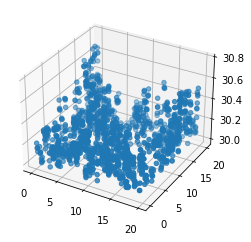

c:\users\ariesmuse\desktop\python\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


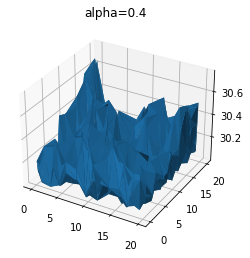

0.1
117.72121937966668
0.3
77.30012781233336
0.4
63.75604440316668
0.5
53.80772292133334
0.6
45.132340581333324
0.7
34.970546388833355
1.0
12.24064619916668


In [16]:
#Next, we can define different alpha value to calculate the surface area and volume.

#我们可以直接通过调用模块来计算不同alpha value的表面积和体积。

#次に、異なるalpha valueの値で表面積を体積を計算する。



fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(waterpoints['xaxis'], waterpoints['yaxis'], waterpoints['zaxis'])
plt.show()
alphavalue = 0.4
alpha_shape = alphashape.alphashape(wp, alphavalue)
alpha_shape.show()
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(*zip(*alpha_shape.vertices), triangles=alpha_shape.faces)
plt.title('alpha='+str(alphavalue))
plt.show()
alpha_shape.volume

range1= [0.1,0.3,0.4,0.5,0.6,0.7,1.0]
vwater = []
for i in range1:
    alphavalue = i
    print(i)
    alpha_shape = alphashape.alphashape(wp, alphavalue)
    print(alpha_shape.volume)
    vwater.append(alpha_shape.volume)


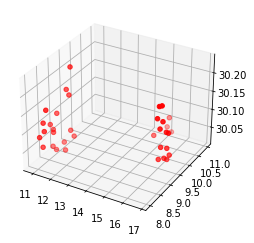

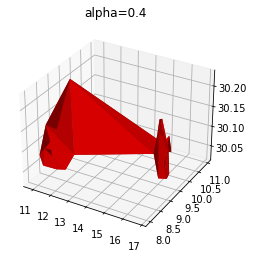

0.02604121433333443

In [18]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(dprotein['xaxis'], dprotein['yaxis'], dprotein['zaxis'],color='red')
plt.show()
alphavalue = 0.4
alpha_shape = alphashape.alphashape(pp, alphavalue)
alpha_shape.show()
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(*zip(*alpha_shape.vertices), triangles=alpha_shape.faces,color='red')
plt.title('alpha='+str(alphavalue))
plt.show()
alpha_shape.volume


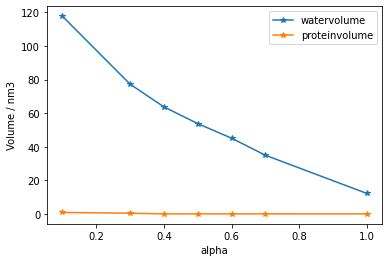

In [20]:
plt.plot(range1,vwater,label='watervolume',marker='*')
plt.plot(range1,vprotein,label='proteinvolume',marker='*')
plt.xlabel('alpha')
plt.ylabel('Volume / nm3')
plt.legend()

          xaxis   yaxis   zaxis
100088   18.279  11.590  30.159
100089   18.332  11.657  30.202
100090   18.224  11.638  30.097
100091   18.278  11.605  30.157
100204    2.586   9.483  30.272
...         ...     ...     ...
1009750   1.356   6.679  30.074
1009956  19.416  15.403  30.274
1009957  19.402  15.493  30.304
1009958  19.503  15.404  30.236
1009959  19.425  15.415  30.273

[1546 rows x 3 columns]
Water area = 788.5505128254313
Water volume = 117.72121937966668
Protein area = 18.08359770652721
Protein volume = 0.8907881815000025
Area ratio = 43.60584246688958


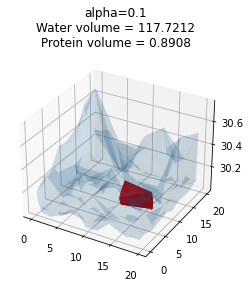

Water area = 774.7995440476751
Water volume = 90.7221728801667
Protein area = 17.754360023638
Protein volume = 0.5503848541666653
Area ratio = 43.639959030689575


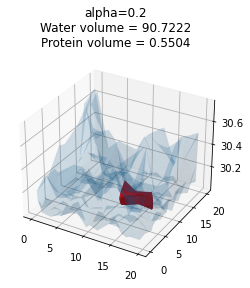

Water area = 759.9528289405843
Water volume = 77.30012781233336
Protein area = 15.807533215636811
Protein volume = 0.4537999628333334
Area ratio = 48.07535866436383


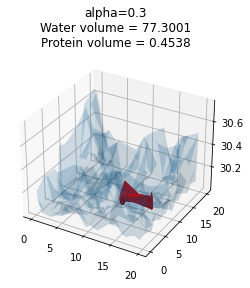

Water area = 755.9509532593258
Water volume = 63.75604440316668
Protein area = 6.16851181422523
Protein volume = 0.02604121433333443
Area ratio = 122.54997250974283


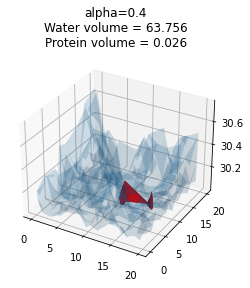

Water area = 687.0764522983734
Water volume = 53.80772292133334
Protein area = 2.242038082333773
Protein volume = 0.03778861766666713
Area ratio = 306.45173144569634


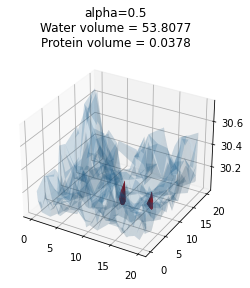

Water area = 631.7823462249364
Water volume = 45.132340581333324
Protein area = 2.2469698093155803
Protein volume = 0.03593808533333337
Area ratio = 281.170821078978


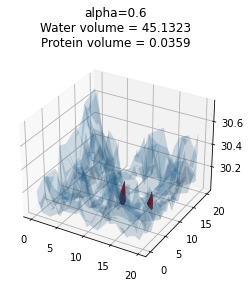

Water area = 588.7716449701114
Water volume = 34.970546388833355
Protein area = 1.6217878364617464
Protein volume = 0.045720408833333205
Area ratio = 363.0386365793902


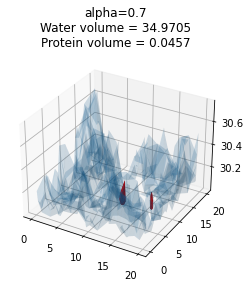

Water area = 520.3323028123334
Water volume = 15.126243526000012
Protein area = 1.6457994882989793
Protein volume = 0.04200615050000002
Area ratio = 316.15777408590907


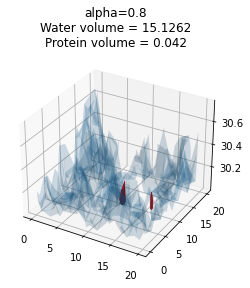

Water area = 467.1466001287657
Water volume = 13.89661465616668
Protein area = 1.642655326048515
Protein volume = 0.04272755066666676
Area ratio = 284.3850397103749


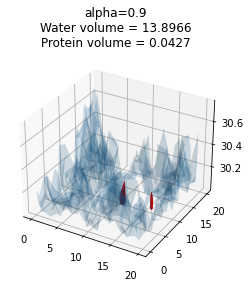

Water area = 416.4113811840931
Water volume = 12.24064619916668
Protein area = 1.5921916906888884
Protein volume = 0.03901960250000054
Area ratio = 261.5334470210215


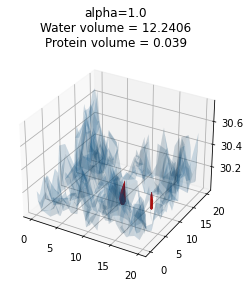

<Figure size 432x288 with 0 Axes>

[ 132.1539978   164.8340651   170.33965214 2448.27463063 1423.9135021
 1255.83597909  764.87825199  360.09592276  325.23780182  313.70504605]


In [23]:
#Here is the set of the entire codes.

#这里是代码的合集。

#ここは、コードのまとめである。


Interface = pd.read_csv(r'D:/Program Files/github/interface.gro',skiprows = 2,delim_whitespace = True,
                        names = ['Residue','Atom','Number','xaxis','yaxis','zaxis'])

dwater = Interface[(Interface["zaxis"] >  30) & (Interface["Residue"].str.contains( "SOL"))]
dprotein = Interface[(Interface["zaxis"] >  30) & (~Interface["Residue"].str.contains( "SOL"))]
waterpoints = dwater.drop(columns = ['Residue','Atom','Number'])
print(waterpoints)
wp = waterpoints.values.tolist()
proteinpoints = dprotein.drop(columns = ['Residue','Atom','Number'])
pp = proteinpoints.values.tolist()

range1= [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
vw = []
vp = []

#fig = plt.figure(figsize=(25,10))
fig = plt.figure()


count = 0
for i in range1:
    alphavalue = i
    alpha_shape = alphashape.alphashape(wp, alphavalue)
    # alpha_shape.show()
    count += 1
    #ax = fig.add_subplot(2, 5, count, projection='3d')
    ax = plt.axes(projection='3d')
    # ax = plt.axes(projection='3d')
    ax.plot_trisurf(*zip(*alpha_shape.vertices), triangles=alpha_shape.faces, alpha=0.1)
    water_volume = alpha_shape.volume
    # plt.title('Water volume = '+str(alpha_shape.volume))
    water_volume = alpha_shape.volume
    water_area = alpha_shape.area
    print('Water area = '+str(water_area))
    print('Water volume = '+str(water_volume))
    # plt.show()
    vw.append(alpha_shape.volume)
    
    alpha_shape = alphashape.alphashape(pp, alphavalue)
    # ax = fig.add_subplot(10, 2, count, projection='3d')
    # ax = plt.axes(projection='3d')
    ax.plot_trisurf(*zip(*alpha_shape.vertices), triangles=alpha_shape.faces,color='red')
    protein_volume = alpha_shape.volume
    protein_area = alpha_shape.area
    print('Protein area = '+str(protein_area))
    title = 'alpha='+str(alphavalue)+'\n'
    title += 'Water volume = '+str(round(water_volume,4))+'\n'
    title += 'Protein volume = '+str(round(alpha_shape.volume, 4))
    plt.title(title)
    print('Protein volume = '+str(protein_volume))
    print('Area ratio = '+str(water_area/protein_area))
    plt.show()
    vp.append(alpha_shape.volume)
plt.savefig('fig.pdf', bbox_inches='tight', pad_inches=0)
plt.show()
ratio = np.array(vw)/np.array(vp)
print(ratio)